In [2]:
import os
from google.cloud import firestore
from google.oauth2 import service_account
import pandas as pd
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


In [5]:
# Path to google service account key file with firebase admin access
SERVICE_ACCOUNT_PATH = os.path.join(os.getcwd(), "../askoverse-app-246b300c551c.json")

# Load the service account key file
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_PATH)

# Initialize Firestore
db = firestore.Client(credentials=credentials)

In [6]:
# Firestore Read Utils

# get a single document from a Firestore collection 
def get_single_document(collection_name, document_id):
    doc = db.collection(collection_name).document(document_id).get()
    return doc.to_dict() if doc.exists else None

# Get all data from a Firestore collection
def get_all_data(collection_name):
    return {doc.id : doc.to_dict() for doc in db.collection(collection_name).stream()}

In [7]:
# Read all polls Data (Dont run it again and again)
all_polls_data = get_all_data('polls')

In [8]:
print(f"Total number of polls in the database = {len(all_polls_data.keys())}")

Total number of polls in the database = 186


In [9]:
# Get only the hashtags field of each poll
poll_hashtags = {key: value.get('hashtags', []) for key, value in all_polls_data.items()}
poll_hashtags

{'03WvZZKDz3GysEJhoyUW': [],
 '06gCr1eOCAKZEYqA4I58': ['#socialpolls',
  '#societypolls',
  '#life',
  '#india',
  '#relationship',
  '#dating'],
 '0AlWBuXqwCIx583hLyhx': ['#life', '#30s', '#youth'],
 '0KvNcuiHABdxtquirxIg': [],
 '0il0izFI02IGv4MLRuOs': ['#politics',
  '#international',
  '#democracy',
  '#discussionpolls',
  '#politicalscience',
  '#academics'],
 '1TZUoUfkqBrQiNkXQza7': ['#habits', '#life', '#random'],
 '1zyrWZJIGcpmT9RaDdQV': ['#instagram',
  '#reels',
  '#transition',
  '#opinionpoll',
  '#malayalam',
  '#troll'],
 '2TOlntjrIQgIPQMdBvZf': ['#marriage',
  '#lifepolls',
  '#sex',
  '#societypolls',
  '#opinionpolls'],
 '2dfnv7Icc3S2trbwiusX': ['#kerala', '#india', '#malayalam', '#geography'],
 '2uHR1ilNhHRy39QhNDmN': ['#travel', '#india', '#Dubai'],
 '2uJnn2qFOdgY1WnNnU7H': ['#engineering',
  '#placement',
  '#btech',
  '#india',
  '#tcs',
  '#accenture'],
 '2uwjz9TWSAY9OhlVsfOo': ['#india',
  '#careerpolls',
  '#opportunity',
  '#opinionpoll',
  '#trollpoll'],
 '30Ue

In [10]:
# Kmeans Clustering on hashtags
all_polls_hashtags_list = [{'id': key, 'hashtags': value} for key, value in poll_hashtags.items()]
# Step 1: Vectorize posts based on hashtags 
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform([post["hashtags"] for post in all_polls_hashtags_list])

/home/lotusquants/projects/flutter_projects/askoverse_research_python/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


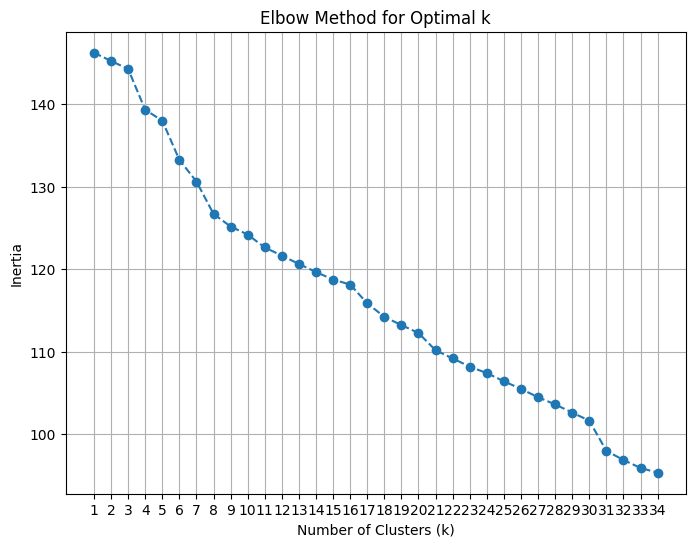

In [11]:
# Getting ideal number of clusters using the elbow method 
inertia = []
for k in range(1, 35):  # Trying from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the inertia values to find the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, 35), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 35))
plt.grid(True)
plt.show()


In [12]:
#  Based on the graph there is no clear elbow but we can see an elbow near 8.. so taking 10 clusters for now

# Step 2: Cluster posts
num_clusters = 10  # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)


KMeans(n_clusters=10, random_state=0)

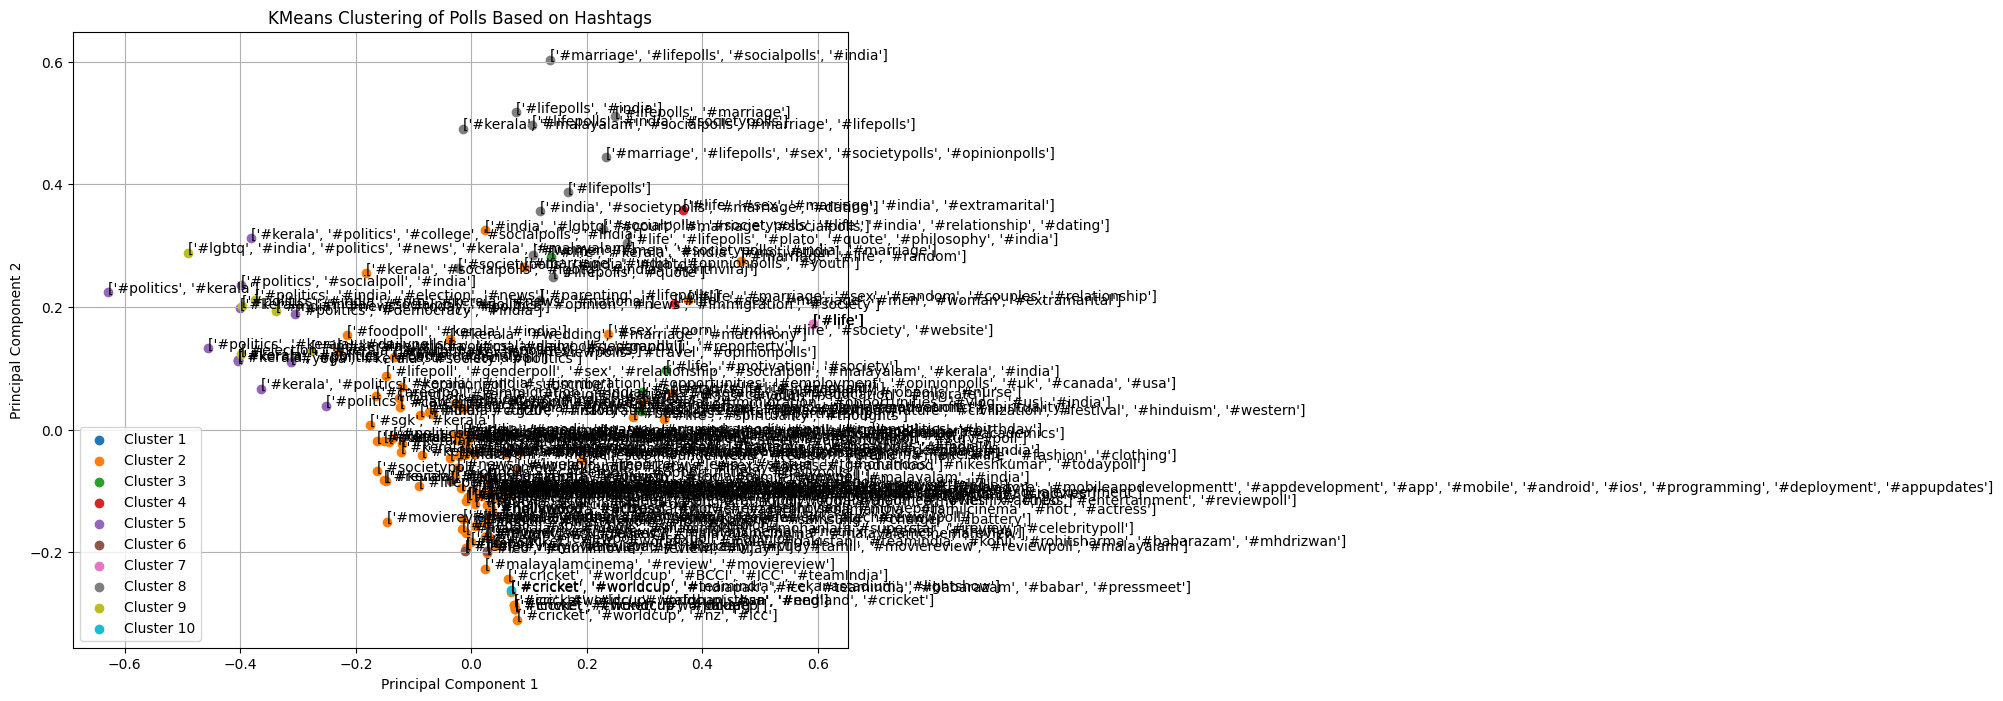

In [13]:
# Step 3: Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Step 4: Plot clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    plt.scatter(X_pca[kmeans.labels_ == cluster_id, 0], 
                X_pca[kmeans.labels_ == cluster_id, 1], 
                label=f'Cluster {cluster_id + 1}')

# Annotate each point with its hashtag(s)
for i, post in enumerate(all_polls_hashtags_list):
    plt.annotate(f'{post["hashtags"]}', (X_pca[i, 0], X_pca[i, 1]))

plt.title('KMeans Clustering of Polls Based on Hashtags')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

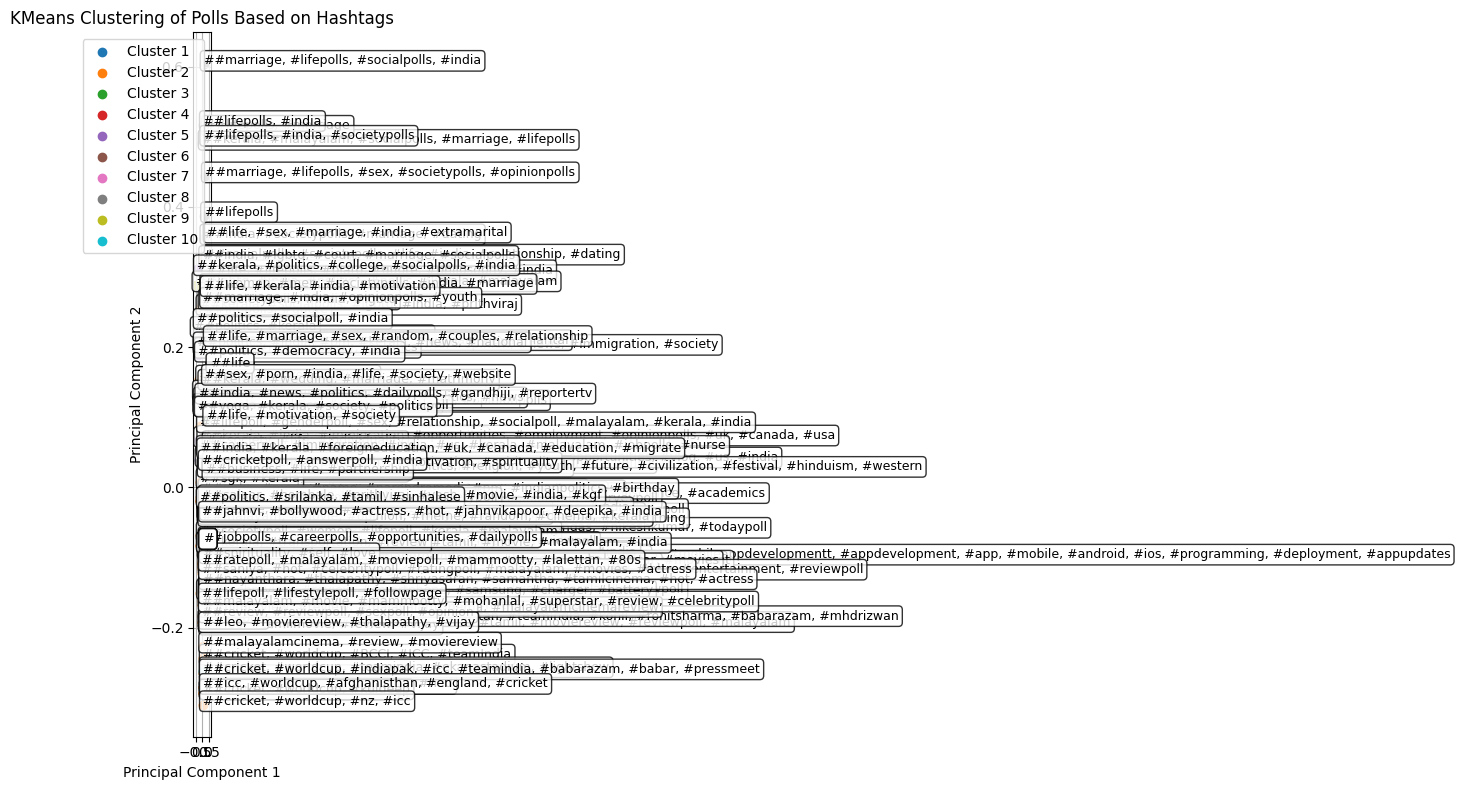

In [157]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming X_pca and kmeans.labels_ are already defined

# Step 4: Plot clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    plt.scatter(X_pca[kmeans.labels_ == cluster_id, 0], 
                X_pca[kmeans.labels_ == cluster_id, 1], 
                label=f'Cluster {cluster_id + 1}')

# Annotate each point with its hashtag(s)
for i, post in enumerate(all_polls_hashtags_list):
    hashtags = ', '.join(post["hashtags"])  # Assuming hashtags is a list of strings
    plt.annotate(f'#{hashtags}', (X_pca[i, 0], X_pca[i, 1]), fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

plt.title('KMeans Clustering of Polls Based on Hashtags')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ensures all annotations fit within the plot area
plt.show()


/tmp/ipykernel_113943/2031552468.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)


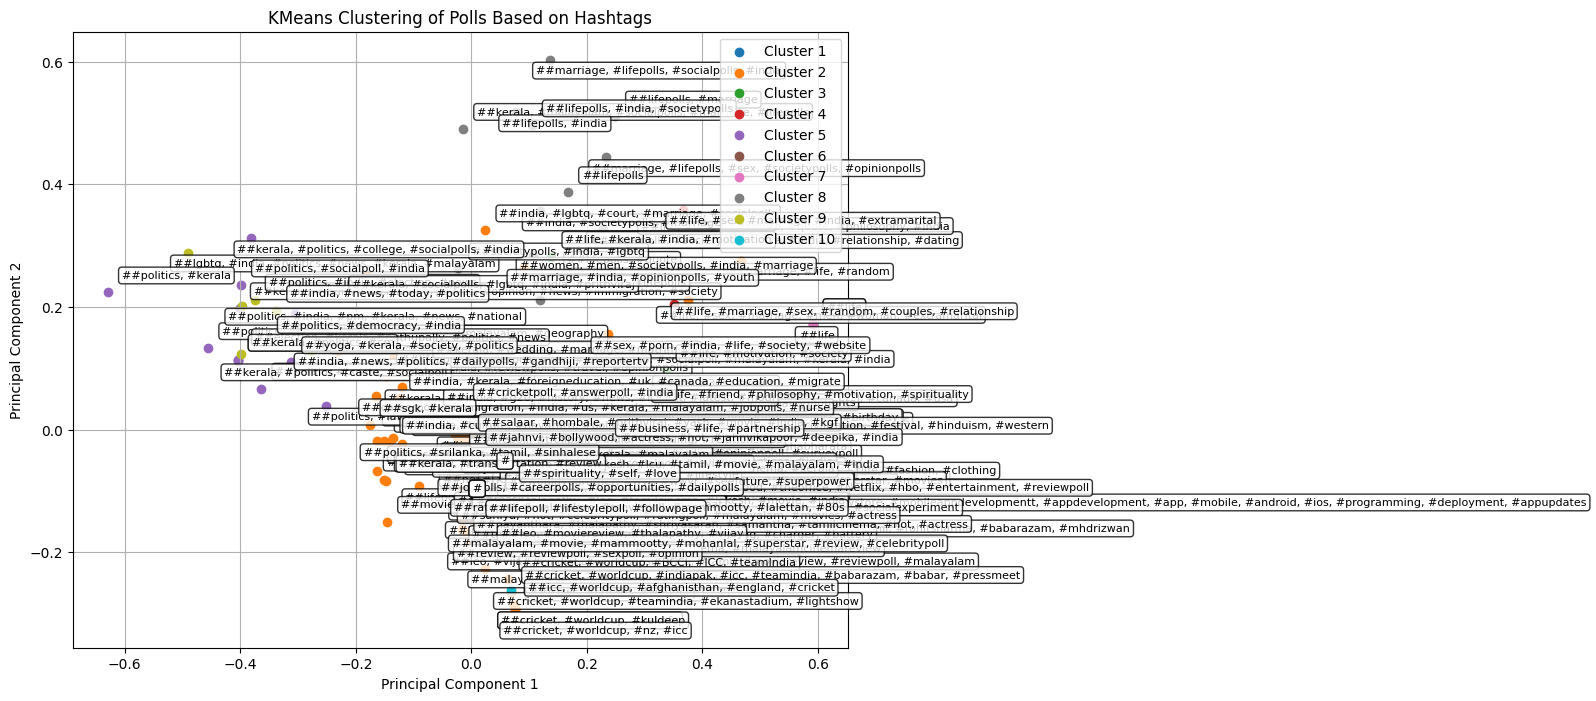

In [161]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assuming X_pca and kmeans.labels_ are already defined
# Assuming all_polls_hashtags_list is a list of dictionaries with "hashtags" as a list of strings

# Step 4: Plot clusters
plt.figure(figsize=(10, 8))

# Define colors for each cluster
colors = plt.cm.get_cmap('tab10', num_clusters)

for cluster_id in range(num_clusters):
    plt.scatter(X_pca[kmeans.labels_ == cluster_id, 0], 
                X_pca[kmeans.labels_ == cluster_id, 1], 
                label=f'Cluster {cluster_id + 1}', 
                color=colors(cluster_id))

# Annotate each point with its hashtag(s)
for i, post in enumerate(all_polls_hashtags_list):
    hashtags = ', '.join(post["hashtags"])  # Assuming hashtags is a list of strings

    # Adjust annotation position to avoid overlap
    if i % 2 == 0:
        offset = (10, 10)
    else:
        offset = (-10, -10)
    
    plt.annotate(f'#{hashtags}', (X_pca[i, 0], X_pca[i, 1]), fontsize=8,
                 xytext=offset, textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))

plt.title('KMeans Clustering of Polls Based on Hashtags')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Place legend on the top right
plt.legend(loc='upper right')

plt.grid(True)

plt.show()


In [14]:
#get top user_hashtags_for a user
# Get all data from a Firestore collection
def get_top_n_user_hashtags(user_id, n):

    user_hashtags_collection_name = "user_hashtags"
    doc =  db.collection(user_hashtags_collection_name).document(user_id).get()

    if not doc.exists:
        return []
    
    return sorted(doc.to_dict().items(), key=lambda item: item[1], reverse=True)[:n]

In [15]:
users_data = get_all_data("users")

# User's preferences (replace with actual user data)
user_preferences = ["#cricket", "#icc"]
user_ids = users_data.keys()
user_interest = {user_id :get_top_n_user_hashtags(user_id, 50) for user_id in user_ids}


In [23]:
user_ids

dict_keys(['100125988467547960387', '102160869386934663700', '102256729171353196957', '103322974267432713508', '105269823456477066166', '107706660343023510416', '110547341497126159198', '111396442525666949404', '111929220758156876577', '112136031355436474234', '112738969339293479182', '112783894183772470156', '113430592772518885685', '114837778551574173749', '115153160789334906988', '117011227819700570913'])

In [24]:
# test 
user_id = "103322974267432713508"
user_preferences = [item[0] for item in user_interest[user_id]]


# Step 3: Find relevant posts for user
user_pref_vector = vectorizer.transform([user_preferences])
user_pref_scores = cosine_similarity(X, user_pref_vector)

# Sort posts by relevance to user preferences
posts_sorted = sorted(zip(all_polls_hashtags_list, user_pref_scores), key=lambda x: x[1], reverse=True)

# Example: Get top posts from the most relevant cluster
top_cluster = kmeans.predict(user_pref_vector)[0]
top_posts_in_cluster = [post for post, score in posts_sorted if kmeans.predict(vectorizer.transform([post["hashtags"]])) == top_cluster]

# Filter out posts with empty hashtag lists
valid_posts = [post for post in top_posts_in_cluster if post['hashtags']]



top_10_posts = []
# Print or return top n valid posts for recommendation
n = 5
for idx, post in enumerate(valid_posts[:n], start=1):
    print(f"Top {idx} - Post ID: {post['id']} - Question: {all_polls_data[post['id']]['question']} - option 1 :{all_polls_data[post['id']]['option1']}")

# Further processing or UI integration can be added based on your application needs


Top 1 - Post ID: PeqsAwqLh0Ae2239DGYL - Question: അമേരിക്കയിൽ NURSE ആകാൻ എളുപ്പമുണ്ടോ? അറിയാവുന്നവർ മാത്രം - option 1 :ശ്രമിച്ചാൽ opportunities ഉണ്ട്
Top 2 - Post ID: IdjPatqV0i1JzqBgTOUy - Question:  - option 1 :ശ്രമിച്ചാൽ അവസരങ്ങൾ ഏറെ ഉള്ള സ്‌ഥലമാണ് US
Top 3 - Post ID: xBa2DpM5rsuk0XTlDWeM - Question:  - option 1 :
Top 4 - Post ID: GbLv4Ww8frfeRp8ua9Zw - Question: As a north Indian what is your review of  traveling to Kerala? Tell from experience please - option 1 :Really God's own country
Top 5 - Post ID: EajFIbwJUrEqhrC7Hss3 - Question: നമ്മുടെ നാട്ടീന്ന് എങ്ങനെങ്കിലും പുറത്തു അമേരിക്ക /കാനഡ /ഓസ്ട്രേലിയ തുടങ്ങിയ രാജ്യത്ത് സെറ്റിൽ ആയാലേ രക്ഷയുള്ളൂ എന്നു പറയുന്നതിൽ കാര്യമുണ്ടോ? - option 1 :ഉണ്ട്. കേരളത്തിൽ നിന്നിട്ട് കാര്യമില്ല


In [151]:
valid_posts

[{'id': 'EMBpBFj1dI9XCRxVJs04', 'hashtags': ['#politics', '#kerala']},
 {'id': 'X3UMbgjQhDvZtjsAuA1e',
  'hashtags': ['#politics', '#kerala', '#dailypolls']},
 {'id': 'BYt0cEGyOUkmKn0qFDjg',
  'hashtags': ['#kerala', '#politics', '#oommenchandy']},
 {'id': 'ccHGEO9ooJgxGhDZaPG0', 'hashtags': ['#kerala', '#politics', '#cm']},
 {'id': 'BE7l7f6sujromYwnmu15',
  'hashtags': ['#kerala', '#politics', '#opinionpoll', '#subscribe']},
 {'id': 'g7QkY1iiZnyjSkEyKCRo',
  'hashtags': ['#kerala', '#politics', '#caste', '#socialpoll']},
 {'id': 'jpmVQILf2dVhiwf5UJge',
  'hashtags': ['#kerala', '#politics', '#college', '#socialpolls', '#india']},
 {'id': 'vZN42npOBbp8Q7RlDajx',
  'hashtags': ['#yoga', '#kerala', '#society', '#politics']},
 {'id': '30UeVmwRFaG812e5WlYi',
  'hashtags': ['#kerala',
   '#india',
   '#socialpoll',
   '#politics',
   '#opinion',
   '#news',
   '#immigration',
   '#society']},
 {'id': 'Me6razo26Rafv05qpBYm', 'hashtags': ['#politics', '#law']},
 {'id': 'jI0fipwj2T5CVBUOHF4n',

In [ ]:

# client = OpenAI(
#   api_key=openai_apikey,  # this is also the default, it can be omitted
# )

# def get_embedding(text):
#     response = client.embeddings.create(
#         input=text,
#         model="text-embedding-ada-002"
#     )
#     return response['data'][0]['embedding']

# embeddings = {hashtag: get_embedding(hashtag) for _, hashtags in poll_hashtags.items() for hashtag in hashtags if hashtag not in embeddings}


In [ ]:
# all_hashtags = {hashtag for _, hashtags in poll_hashtags.items() for hashtag in hashtags}
# all_hashtags

In [ ]:
# clusters = {
#     "Cluster 1: Technology and Development": [
#         '#flutter', '#android', '#ios', '#iphone', '#mobileappdevelopment',
#         '#mobileapps', '#playstore', '#appstore', '#appdevelopment', '#codepush',
#         '#tech', '#technology', '#smartphone', '#gadget'
#     ],
#     "Cluster 2: Entertainment and Media": [
#         '#netflix', '#movies', '#moviereview', '#cinema', '#hollywood',
#         '#bollywood', '#malayalamcinema', '#tamilcinema', '#celebritypoll',
#         '#entertainment', '#series', '#celebritypolls', '#filmreview',
#         '#tv', '#music', '#show'
#     ],
#     "Cluster 3: Sports": [
#         '#cricket', '#icc', '#iccwc', '#teamIndia', '#viratkohli',
#         '#rohitsharma', '#babar', '#babarazam', '#salaar', '#sport', '#worldcup'
#     ],
#     "Cluster 4: Health and Lifestyle": [
#         '#health', '#fitness', '#diet', '#exercise', '#lifestyle',
#         '#food', '#nutrition', '#healthy', '#healthpoll', '#lifepoll', '#lifestylepoll'
#     ],
#     "Cluster 5: Social and Cultural": [
#         '#india', '#usa', '#uk', '#canada', '#srilanka', '#pakistan',
#         '#malayalam', '#tamil', '#hinduism', '#islam', '#christianity',
#         '#culture', '#society', '#tradition', '#religion', '#philosophy'
#     ],
#     "Cluster 6: Politics and Current Affairs": [
#         '#politics', '#indianpolitics', '#election', '#government',
#         '#pm', '#narendramodi', '#bjp', '#congress', '#democracy',
#         '#international', '#world'
#     ],
#     "Cluster 7: Education and Career": [
#         '#education', '#career', '#job', '#employment', '#college',
#         '#students', '#studentpoll', '#placement', '#engineering', '#btech',
#         '#migrate'
#     ],
#     "Cluster 8: Fashion and Lifestyle": [
#         '#fashion', '#clothing', '#style', '#wear', '#shopping',
#         '#apparel', '#trend', '#accessories', '#sunglasses'
#     ],
#     "Cluster 9: Media and Communication": [
#         '#news', '#pressmeet', '#reporter', '#reportertv', '#media',
#         '#socialpoll', '#discussionpolls', '#opinion', '#opinionpoll',
#         '#polls', '#survey', '#surveyresearch'
#     ],
#     "Cluster 10: Miscellaneous": [
#         '#birthday', '#love', '#relationships', '#dating', '#marriage',
#         '#family', '#parenting', '#friends', '#life', '#opportunity',
#         '#motivation', '#inspiration'
#     ]
# }


In [ ]:
# when a new post is added get the list of users based on interest for that post and show them...

# have a list for each user which gets updated  when new posts are added..when user opens the app next time, add these posts also in his reccomendation set

In [168]:
user_hashtags = get_all_data("user_hashtags")

In [176]:
user_hashtags

{'100125988467547960387': {'#review': 4,
  '#icc': 10,
  '#rohitsharma': 10,
  '#kohli': 10,
  '#lightshow': 2,
  '#babarazam': 10,
  '#ekanastadium': 2,
  '#india': 10,
  '#': 0,
  '#transportation': 4,
  '#worldcup': 12,
  '#cricket': 12,
  '#mhdrizwan': 10,
  '#kerala': 4,
  '#pakistan': 10,
  '#teamindia': 12},
 '102160869386934663700': {'#': 0,
  '#review': 3,
  '#lifestle': 3,
  '#men': 3,
  '#clothing': 3,
  '#fashion': 3,
  '#life': 3,
  '#brand': 3,
  '#underwear': 3},
 '102256729171353196957': {'#hot': 1,
  '#news': 22,
  '#hollywood': 1,
  '#reportertv': 2,
  '#religion': 4,
  '#entertainer': 3,
  '#youth': 1,
  '#raw': 3,
  '#hombale': 2,
  '#philosophy': 2,
  '#movie': 10,
  '#spirituality': 8,
  '#rajnikanth': 3,
  '#yash': 2,
  '#moviepoll': 2,
  '#tamil': 6,
  '#mammootty': 4,
  '#women': 5,
  '#malayalamcinema': 7,
  '#opinionpoll': 2,
  '#thoughts': 1,
  '#relationship': 5,
  '#upi': 2,
  '#Dubai': 1,
  '#80s': 2,
  '#oommenchandy': 1,
  '#societypoll': 5,
  '#moviepo

In [178]:
users_data = get_all_data("users")

In [179]:
users_data

{'100125988467547960387': {'timeCreated': DatetimeWithNanoseconds(2023, 8, 30, 16, 45, 59, 763000, tzinfo=datetime.timezone.utc),
  'photoUrl': 'https://lh3.googleusercontent.com/a/AAcHTteUzDCWxj4A1p0Dv0DK7fp86YoeooMXLfRQvoINAjdz-28=s96-c',
  'displayName': 'Neeraj Nambiraj R',
  'id': '100125988467547960387',
  'bio': '',
  'email': 'neerajnambirajr@gmail.com'},
 '102160869386934663700': {'timeCreated': DatetimeWithNanoseconds(2023, 10, 17, 14, 19, 8, 155000, tzinfo=datetime.timezone.utc),
  'photoUrl': 'https://lh3.googleusercontent.com/a/ACg8ocLTM_Ik6yEMzgEPpJqgGiAm_9t7WAIebDJ2ZNHSild8=s96-c',
  'displayName': 'lifestyle101',
  'id': '102160869386934663700',
  'bio': '',
  'email': 'lifestyle101freak@gmail.com'},
 '102256729171353196957': {'timeCreated': DatetimeWithNanoseconds(2023, 8, 1, 9, 31, 14, 98000, tzinfo=datetime.timezone.utc),
  'photoUrl': 'https://lh3.googleusercontent.com/a/AAcHTtfCM6gdLXYP4eDpukANkCyey6RtkpSkn5wd0IHbutRi=s96-c',
  'displayName': 'Politics and Movies',

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


# Extract top 50 hashtags for each user
top_hashtags_per_user = {}
for user_id, hashtags_data in user_hashtags.items():
    sorted_hashtags = sorted(hashtags_data.items(), key=lambda x: x[1], reverse=True)[:50]
    top_hashtags_per_user[user_id] = ' '.join([tag for tag, points in sorted_hashtags])

# Prepare data for sklearn
user_ids = list(top_hashtags_per_user.keys())
hashtags_texts = list(top_hashtags_per_user.values())

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(hashtags_texts)

# Train KNN model
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(X)

# Function to find similar users for a new post
def find_similar_users(new_post_hashtags):
    # Join hashtags into a single string
    new_post_hashtags_str = ' '.join(new_post_hashtags)
    
    # Transform new_post_hashtags into TF-IDF vector
    new_post_vector = vectorizer.transform([new_post_hashtags_str])

    # Find nearest neighbors (similar users)
    distances, indices = knn_model.kneighbors(new_post_vector)

    similar_users = []
    for idx in indices[0]:
        similar_users.append(user_ids[idx])

    return similar_users





In [201]:
# Trying it out
new_post_hashtags = ['#cricket']
similar_users = find_similar_users(new_post_hashtags)
simalr_user_names = {users_data[item]['displayName'] for item in similar_users if item in users_data.keys()}
print("Users interested in the new post:", simalr_user_names)

Users interested in the new post: {'Neeraj Nambiraj R', 'Nuage Laboratoire', 'John Smith', 'Life_Living_Society'}


['110547341497126159198',
 '105269823456477066166',
 '100125988467547960387',
 '115153160789334906988',
 '108501876606897577789']

In [184]:
users_data

{'100125988467547960387': {'timeCreated': DatetimeWithNanoseconds(2023, 8, 30, 16, 45, 59, 763000, tzinfo=datetime.timezone.utc),
  'photoUrl': 'https://lh3.googleusercontent.com/a/AAcHTteUzDCWxj4A1p0Dv0DK7fp86YoeooMXLfRQvoINAjdz-28=s96-c',
  'displayName': 'Neeraj Nambiraj R',
  'id': '100125988467547960387',
  'bio': '',
  'email': 'neerajnambirajr@gmail.com'},
 '102160869386934663700': {'timeCreated': DatetimeWithNanoseconds(2023, 10, 17, 14, 19, 8, 155000, tzinfo=datetime.timezone.utc),
  'photoUrl': 'https://lh3.googleusercontent.com/a/ACg8ocLTM_Ik6yEMzgEPpJqgGiAm_9t7WAIebDJ2ZNHSild8=s96-c',
  'displayName': 'lifestyle101',
  'id': '102160869386934663700',
  'bio': '',
  'email': 'lifestyle101freak@gmail.com'},
 '102256729171353196957': {'timeCreated': DatetimeWithNanoseconds(2023, 8, 1, 9, 31, 14, 98000, tzinfo=datetime.timezone.utc),
  'photoUrl': 'https://lh3.googleusercontent.com/a/AAcHTtfCM6gdLXYP4eDpukANkCyey6RtkpSkn5wd0IHbutRi=s96-c',
  'displayName': 'Politics and Movies',

In [32]:
 import requests

response = requests.post("https://us-central1-askoverse-app.cloudfunctions.net/train_poll_hashtags_kmeans_model")
response.content

b'Model trained and saved successfully.'